# Chapter 4: Basics of Neural Networks

In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import time
%matplotlib inline 

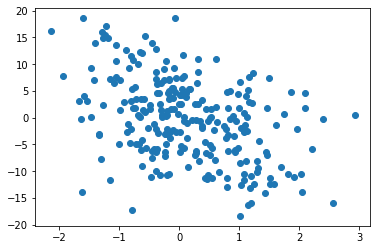

In [2]:
data = np.random.multivariate_normal([0,0],[[1,-3],[-3,52]],250)
X = torch.tensor(data[:,0]).type(torch.FloatTensor)
y = torch.tensor(data[:,1]).type(torch.FloatTensor)
plt.scatter(X,y)


## Linear model

We will focus on a linear model of the form $y = w_0 + w_1x + \epsilon$. Where $\epsilon$ is assumed to be gaussian noise with zero mean and variance $\sigma^2$.


**Analytic solution**

w: tensor([ 0.1852, -3.4033])


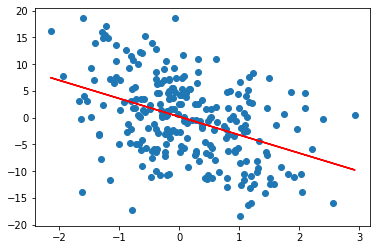

In [3]:
X_ = torch.cat((torch.ones(X.size()).unsqueeze(dim=1),X.unsqueeze(dim=1)),1)
w = torch.inverse(X_.T @ X_) @ X_.T @ y
print('w:',w)
plt.plot(X, X_ @ w,'r')
plt.scatter(X,y)

### Gradient descent
**Gradient descent with pytorch autograd**

In [4]:
def r_emp(w,X,y):
     return (y - X @ w).T @ (y - X @ w)

In [5]:
def min_r_emp_1(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    
    for i in range(k):
        if w.grad is not None:
            w.grad.zero_()
        l_p = r_emp(w,X,y)
        l_p.backward()
        w = (w - lr*w.grad).detach().requires_grad_()
    return w

In [6]:
w_g = min_r_emp_1(X_,y)
print('Solution: ',w_g)

Solution:  tensor([ 0.1852, -3.4033], requires_grad=True)


C:\Users\dohr\AppData\Local\Temp\ipykernel_45092\2613419657.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2985.)
  return (y - X @ w).T @ (y - X @ w)


**Gradient descent with pytorch autograd and optimizer**

In [7]:
def min_r_emp_2(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1],requires_grad=True)
    optimizer = optim.SGD([w],lr=lr)
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        optimizer.zero_grad()
        l_p.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l_p))
    return w

In [8]:
w_g_2 = min_r_emp_2(X_,y,lr=0.001,k=500)
print('Solution:',w_g_2)

Epoch 0, Loss 16481.263672
Epoch 100, Loss 11814.716797
Epoch 200, Loss 11814.716797
Epoch 300, Loss 11814.716797
Epoch 400, Loss 11814.716797
Solution: tensor([ 0.1852, -3.4033], requires_grad=True)


**Gradient descent with manual differentiation**

In [9]:
def dw_r_emp(w,X,y):
    return X.T @ (X @ w - y)

In [10]:
def min_r_emp_3(X,y,lr=1e-3,k=500):
    w = torch.ones(X.shape[1])
    
    for i in range(k):
        l_p = r_emp(w,X,y)
        dw = dw_r_emp(w,X,y)
        w = (w - lr*dw)
    return w

In [11]:
w_g_3 = min_r_emp_3(X_,y,lr=0.001,k=500)
print('Solution:',w_g_3)

Solution: tensor([ 0.1852, -3.4033])


Define a general training loop

In [12]:
def training_loop(X,y,w,optimizer,model,loss_fn,lr=1e-3,n_epochs=5000):
   
    for i in range(n_epochs):
        y_p = model(w,X)
        loss = loss_fn(y_p,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,loss))

    print('Result:',w)
    return w

In [13]:
def model(w,X):
    return X @ w

def loss_fn(y_p,y):
    return 0.5*((y_p - y)**2).sum()

In [14]:
w = torch.ones(X_.shape[1],requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

training_loop(X_,y,w,optimizer,model,nn.MSELoss())

Epoch 0, Loss 65.925064
Epoch 500, Loss 50.148067
Epoch 1000, Loss 47.735043
Epoch 1500, Loss 47.341644
Epoch 2000, Loss 47.273853
Epoch 2500, Loss 47.261665
Epoch 3000, Loss 47.259407
Epoch 3500, Loss 47.258972
Epoch 4000, Loss 47.258896
Epoch 4500, Loss 47.258877
Result: tensor([ 0.1848, -3.4024], requires_grad=True)


tensor([ 0.1848, -3.4024], requires_grad=True)

## Linear neuron with activation

### Sigmoid

generate 2-D testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_45092\4048414768.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


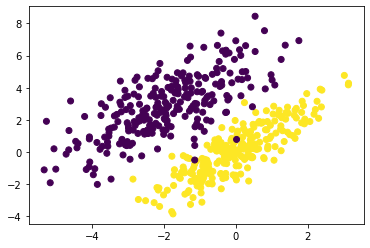

In [15]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,3],[[2,2],[2,4]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2),0)
y = torch.cat((torch.ones(250),torch.zeros(250)),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [16]:
def model_sigmoid(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.sigmoid(x_temp @ w)

In [17]:
def loss_sigmoid(y_p,y):
    r = -torch.log(y_p)*y - (1-y)*torch.log(1-y_p)
    return r.sum()

In [18]:
def train_loop_sigmdoid(X,y,lr=1e-4,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
   # print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_sigmoid(X,w)
        l = loss_sigmoid(y_p,y)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad)
        w.detach_()
        w.requires_grad_()

    return w

In [19]:
w = train_loop_sigmdoid(X,y,lr=1e-3,n_epoch=500)

Epoch 0, Loss 846.430603
Epoch 100, Loss 37.391579
Epoch 200, Loss 28.624029
Epoch 300, Loss 25.254070
Epoch 400, Loss 23.470222


In [20]:
y_p = model_sigmoid(X,w).detach()


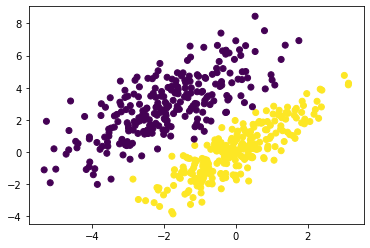

In [21]:
y_p[y_p < 0.5] = 0
y_p[y_p >= 0.5] = 1
plt.scatter(X[:,0],X[:,1],c=y_p)

### Sigmoid with cross entropy loss from pytorch

In [22]:
def train_loop_sigmdoid_2(X,y,loss_fn,lr=1e-3,n_epoch=500):
    w = torch.ones(3,requires_grad=True)
   # print(w)
    for i in range(n_epoch):
        if w.grad is not None:
            w.grad.zero_()

        y_p = model_sigmoid(X,w)
        l = loss_fn(y_p,y)
        l.backward()

        if i % 100 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        w = (w - lr * w.grad)
        w.detach_()
        w.requires_grad_()

    return w

In [23]:
loss_bce = nn.BCELoss(reduction='sum')
w = train_loop_sigmdoid_2(X,y,loss_bce,lr=1e-4,n_epoch=5000)
y_p = model_sigmoid(X,w).detach()

Epoch 0, Loss 846.430603
Epoch 100, Loss 95.231331
Epoch 200, Loss 75.883408
Epoch 300, Loss 64.430008
Epoch 400, Loss 56.785675
Epoch 500, Loss 51.319489
Epoch 600, Loss 47.214115
Epoch 700, Loss 44.015175
Epoch 800, Loss 41.450466
Epoch 900, Loss 39.346962
Epoch 1000, Loss 37.589481
Epoch 1100, Loss 36.098385
Epoch 1200, Loss 34.816822
Epoch 1300, Loss 33.703117
Epoch 1400, Loss 32.726025
Epoch 1500, Loss 31.861637
Epoch 1600, Loss 31.091377
Epoch 1700, Loss 30.400543
Epoch 1800, Loss 29.777369
Epoch 1900, Loss 29.212320
Epoch 2000, Loss 28.697586
Epoch 2100, Loss 28.226707
Epoch 2200, Loss 27.794283
Epoch 2300, Loss 27.395786
Epoch 2400, Loss 27.027361
Epoch 2500, Loss 26.685743
Epoch 2600, Loss 26.368107
Epoch 2700, Loss 26.072008
Epoch 2800, Loss 25.795361
Epoch 2900, Loss 25.536304
Epoch 3000, Loss 25.293226
Epoch 3100, Loss 25.064716
Epoch 3200, Loss 24.849495
Epoch 3300, Loss 24.646463
Epoch 3400, Loss 24.454622
Epoch 3500, Loss 24.273081
Epoch 3600, Loss 24.101053
Epoch 3700, 

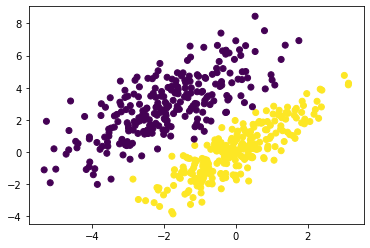

In [24]:
y_p[y_p < 0.5] = 0
y_p[y_p >= 0.5] = 1
plt.scatter(X[:,0],X[:,1],c=y_p)

### Softmax classification

generate testdata

C:\Users\dohr\AppData\Local\Temp\ipykernel_45092\3254666763.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)


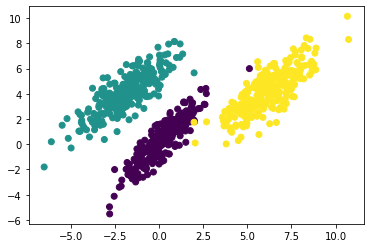

In [25]:
X1 = torch.tensor(np.random.multivariate_normal([0,0],[[1,2],[2,3]],250)).type(torch.FloatTensor)
X2 = torch.tensor(np.random.multivariate_normal([-2,4],[[2,2],[2,3]],250)).type(torch.FloatTensor)
X3 = torch.tensor(np.random.multivariate_normal([6,4],[[2,2],[2,3]],250)).type(torch.FloatTensor)
X = torch.cat((X1,X2,X3),0)
y = torch.cat((torch.zeros(250),torch.ones(250),torch.ones(250)*2),0)

plt.scatter(X[:,0],X[:,1],c=y)

In [26]:
def model_softmax(X,w,bias=True):
    x_temp = torch.cat((torch.ones(X.shape[0]).unsqueeze(dim=1),X),dim=1)
    return torch.softmax(x_temp @ w.T,dim = 1)

def train_loop_softmax(X,y,optimizer, loss_fn,n_epoch=500):
#    w = torch.randn(3,3,requires_grad=True)

    for i in range(n_epoch):
        optimizer.zero_grad()

        w = optimizer.param_groups[0]['params'][0]

        y_p = model_softmax(X,w)
        l = loss_fn(y_p,y)
        l.backward()

        if i % 500 == 0:
            print('Epoch %d, Loss %f' % (i,l))

        optimizer.step()
    return w

In [27]:
y_one_hot = nn.functional.one_hot(y.type(torch.LongTensor),num_classes=3)
y_one_hot = y_one_hot.type(torch.FloatTensor)
loss_ce = nn.CrossEntropyLoss(reduction='sum')
w = torch.randn(3,3,requires_grad=True)
optimizer = optim.SGD([w],lr=1e-3)

In [28]:
w = train_loop_softmax(X,y_one_hot,optimizer,loss_ce,n_epoch=5000)


Epoch 0, Loss 852.163879
Epoch 500, Loss 425.423157
Epoch 1000, Loss 420.534088
Epoch 1500, Loss 419.156921
Epoch 2000, Loss 418.467407
Epoch 2500, Loss 418.042023
Epoch 3000, Loss 417.749084
Epoch 3500, Loss 417.532959
Epoch 4000, Loss 417.365875
Epoch 4500, Loss 417.232117


In [29]:
y_p = model_softmax(X,w)
y_c = y_p.argmax(dim=1)

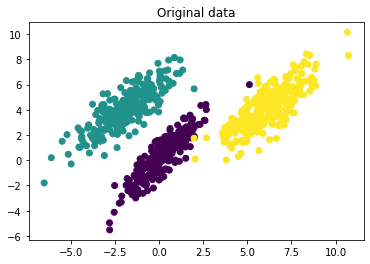

In [30]:
plt.title('Original data')
plt.scatter(X[:,0],X[:,1],c=y)

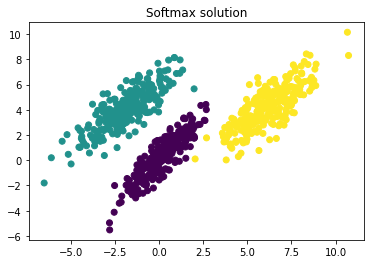

In [31]:
plt.title('Softmax solution')
plt.scatter(X[:,0],X[:,1],c=y_c)

## Example: aproximate sin(x)

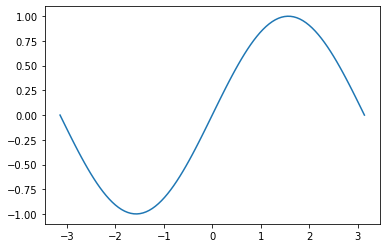

In [32]:
x = torch.linspace(-torch.pi,torch.pi,steps=100)
y = torch.sin(x)
plt.plot(x,y)

In [33]:
def train_loop_seq(X,y,model,optimizer, loss_fn,n_epoch=5000):
#    w = torch.randn(3,3,requires_grad=True)

    start = time.time()
    step = int(n_epoch/10)
    for i in range(n_epoch):
        optimizer.zero_grad()


        y_p = model(X)
        l = loss_fn(y_p,y)
        l.backward()

        if i % step == 0:
            print('Epoch %d, Loss %f' % (i,l))

        optimizer.step()
    end = time.time()
    print('------------------------------')
    print('training loop finished. ')
    print(f'training time: {end-start}')
    print('Loss: %f' % l)

x_t = x.unsqueeze(dim=1)
x_t.requires_grad_()
y_t = y.unsqueeze(dim=1)
loss_mse = nn.MSELoss()

### segential model 2x1250 + ReLU with 1500 epochs

In [34]:
seq_model = nn.Sequential(
    nn.Linear(1,1250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250,1250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=1500)

Epoch 0, Loss 0.712101
Epoch 150, Loss 0.007626
Epoch 300, Loss 0.002209
Epoch 450, Loss 0.000950
Epoch 600, Loss 0.000513
Epoch 750, Loss 0.000319
Epoch 900, Loss 0.000217
Epoch 1050, Loss 0.000158
Epoch 1200, Loss 0.000120
Epoch 1350, Loss 0.000094
------------------------------
training loop finished. 
training time: 23.723520040512085
Loss: 0.000075


### seq model 2x1250 + Tanh

In [35]:
seq_model = nn.Sequential(
    nn.Linear(1,1250,bias=True),
    nn.Tanh(),
    nn.Linear(1250,1250,bias=True),
    nn.Tanh(),
    nn.Linear(1250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=1500)

Epoch 0, Loss 0.682862
Epoch 150, Loss 0.011690
Epoch 300, Loss 0.006423
Epoch 450, Loss 0.004347
Epoch 600, Loss 0.002833
Epoch 750, Loss 0.003450
Epoch 900, Loss 0.002318
Epoch 1050, Loss 0.001841
Epoch 1200, Loss 0.003998
Epoch 1350, Loss 0.002287
------------------------------
training loop finished. 
training time: 22.194936513900757
Loss: 0.001169


### segential model 3x250 + ReLU with 2500 epochs

In [36]:
seq_model = nn.Sequential(
    nn.Linear(1,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.502542
Epoch 250, Loss 0.029577
Epoch 500, Loss 0.007335
Epoch 750, Loss 0.002794
Epoch 1000, Loss 0.001285
Epoch 1250, Loss 0.000707
Epoch 1500, Loss 0.000442
Epoch 1750, Loss 0.000301
Epoch 2000, Loss 0.000216
Epoch 2250, Loss 0.000163
------------------------------
training loop finished. 
training time: 8.086245775222778
Loss: 0.000128


### segential model 4x250 + ReLU with 2500 epochs

In [37]:
seq_model = nn.Sequential(
    nn.Linear(1,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,250,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(250,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.496045
Epoch 250, Loss 0.053336
Epoch 500, Loss 0.012122
Epoch 750, Loss 0.003731
Epoch 1000, Loss 0.001448
Epoch 1250, Loss 0.000680
Epoch 1500, Loss 0.000378
Epoch 1750, Loss 0.000235
Epoch 2000, Loss 0.000158
Epoch 2250, Loss 0.000112
------------------------------
training loop finished. 
training time: 12.324678897857666
Loss: 0.000083


### segential model 2x500 + ReLU with 2500 epochs

In [38]:
seq_model = nn.Sequential(
    nn.Linear(1,500,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(500,500,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(500,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.586980
Epoch 250, Loss 0.006951
Epoch 500, Loss 0.004842
Epoch 750, Loss 0.003153
Epoch 1000, Loss 0.001915
Epoch 1250, Loss 0.001382
Epoch 1500, Loss 0.000988
Epoch 1750, Loss 0.000749
Epoch 2000, Loss 0.000623
Epoch 2250, Loss 0.000536
------------------------------
training loop finished. 
training time: 9.943501234054565
Loss: 0.000419


### segential model 10x100 + ReLU with 2500 epochs

In [39]:
seq_model = nn.Sequential(
    nn.Linear(1,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,100,bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(100,1),)

optimizer = optim.SGD(seq_model.parameters(),lr=1e-2)
train_loop_seq(x_t,y_t,seq_model,optimizer,loss_mse,n_epoch=2500)

Epoch 0, Loss 0.495110
Epoch 250, Loss 0.494967
Epoch 500, Loss 0.494948
Epoch 750, Loss 0.494928
Epoch 1000, Loss 0.494909
Epoch 1250, Loss 0.494889
Epoch 1500, Loss 0.494866
Epoch 1750, Loss 0.494841
Epoch 2000, Loss 0.494810
Epoch 2250, Loss 0.494775
------------------------------
training loop finished. 
training time: 9.302589416503906
Loss: 0.494735


## Example approximate sin(x) + noise

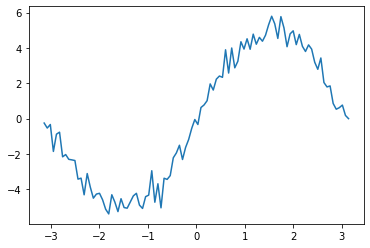

In [40]:
x = torch.linspace(-torch.pi,torch.pi,steps=100)
y = 5*torch.sin(x) + np.random.normal(0,0.5,100)
y = y.type(torch.FloatTensor)
x_t = x.unsqueeze(dim=1)
x_t.requires_grad_()
y_t = y.unsqueeze(dim=1)
plt.plot(x,y)

### segential model 2x1250 + ReLU with 1500 epochs

In [41]:
seq_model = nn.Sequential(
    nn.Linear(1, 1250, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250, 1250, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(1250, 1), )

optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)
train_loop_seq(x_t, y_t, seq_model, optimizer, loss_mse, n_epoch=2500)

Epoch 0, Loss 11.702888
Epoch 250, Loss 1.677815
Epoch 500, Loss 1.163606
Epoch 750, Loss 0.920582
Epoch 1000, Loss 0.752794
Epoch 1250, Loss 0.648262
Epoch 1500, Loss 0.567845
Epoch 1750, Loss 0.498479
Epoch 2000, Loss 0.449010
Epoch 2250, Loss 0.407817
------------------------------
training loop finished. 
training time: 46.734281063079834
Loss: 0.374836


## Convolutional Network

In [2]:
data = pd.read_csv('MSFT.csv')
data_tensor = torch.tensor(data.to_numpy()[:,1:5].astype(float))
data_tensor

tensor([[8.8542e-02, 1.0156e-01, 8.8542e-02, 9.7222e-02],
        [9.7222e-02, 1.0243e-01, 9.7222e-02, 1.0069e-01],
        [1.0069e-01, 1.0330e-01, 1.0069e-01, 1.0243e-01],
        ...,
        [2.8890e+02, 2.8925e+02, 2.8556e+02, 2.8615e+02],
        [2.8208e+02, 2.8246e+02, 2.7722e+02, 2.7775e+02],
        [2.7644e+02, 2.7886e+02, 2.7540e+02, 2.7644e+02]], dtype=torch.float64)

In [3]:
def train_loop_conv(train_x,train_y,val_x,val_y,model,optimizer, loss_fn,n_epoch=5000):
    start = time.time()
    step = int(n_epoch/10)
    t_loss = []
    v_loss = []
    for i in range(n_epoch):
        train_y_p = model(train_x)
        train_loss = loss_fn(train_y_p,train_y)
        t_loss.append(train_loss.item())

        val_y_p = model(val_x)
        val_loss = loss_fn(val_y_p,val_y)
        v_loss.append(val_loss.item())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if i % step == 0:
            print('Epoch: %d, Training-Loss: %f, Validation-Loss: %f' % (i,train_loss,val_loss))

    end = time.time()
    print('------------------------------')
    print('training loop finished. ')
    print(f'training time: {end-start}')
    print('Training-Loss: %f, Validation-Loss: %f' % (train_loss,val_loss))

    return t_loss,v_loss

def get_train_data(data,label_col_idx,size=5):
    n_samples =int(data.shape[0] / size) + (data.shape[0] % size)
    n_channels = data.shape[1]
    X_ = torch.zeros((n_samples,n_channels,size))
    y_ = torch.zeros(n_samples)
    for i in range(n_samples):
        for j in range(n_channels):
            X_[i,j] = data[i:i+size,j]
        y_[i] = data[i+size,label_col_idx]
    return X_ , y_



In [4]:
conv_model_norm = nn.Sequential(
    nn.Conv1d(4,128,3,padding=1),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Conv1d(128,128,5,padding=2),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Flatten(),
    nn.Linear(256,1)
)

loss_L1 = nn.L1Loss()

Prepare data, standardization and normalization

In [5]:
data_min = data_tensor.min(dim=0)[0]
data_max = data_tensor.max(dim=0)[0]
data_mean = data_tensor.mean(dim=0,keepdim=True)
data_std = data_tensor.std(dim=0)
data_normalized = (data_tensor - data_min) / (data_max - data_min)
data_standardized = (data_tensor - data_mean) / data_std

X, y = get_train_data(data_normalized,3,10)
input_data = X
input_labels = y.unsqueeze(dim=1)

n_samples = X.shape[0]
n_val = int (0.2 * n_samples)

shuffeled_indices = torch.randperm(n_samples)

train_indices = shuffeled_indices[:-n_val]
val_indices = shuffeled_indices[-n_val:]

optimizer = optim.Adam(conv_model_norm.parameters(),lr=1e-3)
t_loss, v_loss = train_loop_conv(input_data[train_indices],input_labels[train_indices],input_data[val_indices],input_labels[val_indices], conv_model_norm, optimizer, loss_L1, n_epoch=5000)

Epoch: 0, Training-Loss: 0.033165, Validation-Loss: 0.033189
Epoch: 500, Training-Loss: 0.002655, Validation-Loss: 0.002676
Epoch: 1000, Training-Loss: 0.003993, Validation-Loss: 0.004007
Epoch: 1500, Training-Loss: 0.000484, Validation-Loss: 0.000474
Epoch: 2000, Training-Loss: 0.001649, Validation-Loss: 0.001655
Epoch: 2500, Training-Loss: 0.000294, Validation-Loss: 0.000287
Epoch: 3000, Training-Loss: 0.000288, Validation-Loss: 0.000280
Epoch: 3500, Training-Loss: 0.000196, Validation-Loss: 0.000196
Epoch: 4000, Training-Loss: 0.000620, Validation-Loss: 0.000618
Epoch: 4500, Training-Loss: 0.000575, Validation-Loss: 0.000577
------------------------------
training loop finished. 
training time: 135.42563319206238
Training-Loss: 0.000343, Validation-Loss: 0.000346


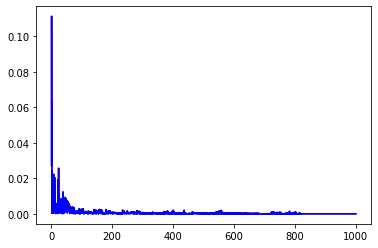

In [181]:
plt.plot(np.linspace(1,1000,num=5000),t_loss,'r')
plt.plot(np.linspace(1,1000,num=5000),v_loss,'b')

In [165]:
t_loss

[tensor(6.0231e-05, grad_fn=<L1LossBackward0>),
 tensor(0.0025, grad_fn=<L1LossBackward0>),
 tensor(0.0012, grad_fn=<L1LossBackward0>),
 tensor(0.0009, grad_fn=<L1LossBackward0>),
 tensor(0.0010, grad_fn=<L1LossBackward0>),
 tensor(0.0006, grad_fn=<L1LossBackward0>),
 tensor(0.0003, grad_fn=<L1LossBackward0>),
 tensor(0.0005, grad_fn=<L1LossBackward0>),
 tensor(0.0001, grad_fn=<L1LossBackward0>),
 tensor(0.0005, grad_fn=<L1LossBackward0>),
 tensor(0.0005, grad_fn=<L1LossBackward0>),
 tensor(0.0001, grad_fn=<L1LossBackward0>),
 tensor(0.0006, grad_fn=<L1LossBackward0>),
 tensor(0.0007, grad_fn=<L1LossBackward0>),
 tensor(0.0004, grad_fn=<L1LossBackward0>),
 tensor(0.0002, grad_fn=<L1LossBackward0>),
 tensor(0.0005, grad_fn=<L1LossBackward0>),
 tensor(0.0004, grad_fn=<L1LossBackward0>),
 tensor(0.0002, grad_fn=<L1LossBackward0>),
 tensor(0.0004, grad_fn=<L1LossBackward0>),
 tensor(0.0006, grad_fn=<L1LossBackward0>),
 tensor(0.0004, grad_fn=<L1LossBackward0>),
 tensor(0.0001, grad_fn=<L1L

In [171]:
t = torch.tensor( [1])

In [172]:
t

tensor([1])

In [173]:
t.item()

1